In [1]:
# Name : RNN_Baseline

In [2]:
#!pip install -q torch
#!pip install -q darts
#!pip install -q torchmetrics

In [3]:
from torchmetrics.regression import SymmetricMeanAbsolutePercentageError
import torch
import numpy as np
import pandas as pd
from darts import TimeSeries

In [4]:

#from darts.utils.timeseries_generation import (
    #gaussian_timeseries,
    #linear_timeseries,
    #sine_timeseries,
#)
from darts.models import (BlockRNNModel)
from darts.models import (TFTModel)
from darts.explainability.tft_explainer import TFTExplainer
#from darts.metrics import mape, smape, mae
from darts.metrics import smape
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
#from darts.datasets import AirPassengersDataset, MonthlyMilkDataset, ElectricityDataset


/Users/jj/.pyenv/versions/taxifare-env/envs/jawP_projectV2/lib/python3.10/site-packages/statsforecast/utils.py:237: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),


In [5]:
import logging

logging.disable(logging.CRITICAL)

import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

%matplotlib inline

# for reproducibility
torch.manual_seed(1)
np.random.seed(1)

In [6]:
# import from Föhn pynb nicer, but for now Copy paste

In [7]:

!pip install openmeteo-requests
!pip install requests-cache retry-requests numpy pandas


import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)


In [8]:


def make_dataframe(openmeteo_response):

    hourly = openmeteo_response.Hourly()
    _start = pd.to_datetime(hourly.Time(), unit = "s", utc = True)
    _end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True)
    _delta = pd.Timedelta(seconds = hourly.Interval())

    data = {
        "date": pd.date_range(_start, _end, freq=_delta, inclusive="left"),
        "temperature_2m": hourly.Variables(0).ValuesAsNumpy(),
        "surface_pressure": hourly.Variables(1).ValuesAsNumpy(),
        "wind_speed_10m": hourly.Variables(2).ValuesAsNumpy(),
        "wind_direction_10m": hourly.Variables(3).ValuesAsNumpy(),
        "wind_gusts_10m": hourly.Variables(4).ValuesAsNumpy(),
    }

    return pd.DataFrame(data).set_index("date")

In [9]:
# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": [47.36, 46, 47.26, 46.5],
	"longitude": [8.55, 8.95, 11.39, 11.35],
	"start_date": "2024-02-10",
	"end_date": "2024-03-15",
	"hourly": ["temperature_2m", "surface_pressure", "wind_speed_10m", "wind_direction_10m", "wind_gusts_10m"]
}
data = openmeteo.weather_api(url, params=params)
data = dict(zip(("Zurich", "Lugano", "Innsbruck", "Bolzano"), data))
data = pd.concat({key: make_dataframe(val) for key, val in data.items()})

city_codes = {"Zurich": 1, "Lugano": 2, "Innsbruck": 3, "Bolzano": 4}
data['city_code'] = data.index.get_level_values(0).map(city_codes)

Extract 'Time' and 'Date' From 'a'

In [10]:
data.reset_index(inplace=True)
data['Time'] = data['date'].dt.time
data['Date'] = data['date'].dt.date
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3360 entries, 0 to 3359
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   level_0             3360 non-null   object             
 1   date                3360 non-null   datetime64[ns, UTC]
 2   temperature_2m      3360 non-null   float32            
 3   surface_pressure    3360 non-null   float32            
 4   wind_speed_10m      3360 non-null   float32            
 5   wind_direction_10m  3360 non-null   float32            
 6   wind_gusts_10m      3360 non-null   float32            
 7   city_code           3360 non-null   int64              
 8   Time                3360 non-null   object             
 9   Date                3360 non-null   object             
dtypes: datetime64[ns, UTC](1), float32(5), int64(1), object(3)
memory usage: 197.0+ KB


Convert pd_todatetime to float64

In [11]:
data['Time'] = pd.to_datetime(data['Time'], format='%H:%M:%S', errors='ignore')
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d', errors='ignore')
data['Date'] = data[('Date')].values.astype('float64')
data['Time'] = data[('Time')].values.astype('float64')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3360 entries, 0 to 3359
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   level_0             3360 non-null   object             
 1   date                3360 non-null   datetime64[ns, UTC]
 2   temperature_2m      3360 non-null   float32            
 3   surface_pressure    3360 non-null   float32            
 4   wind_speed_10m      3360 non-null   float32            
 5   wind_direction_10m  3360 non-null   float32            
 6   wind_gusts_10m      3360 non-null   float32            
 7   city_code           3360 non-null   int64              
 8   Time                3360 non-null   float64            
 9   Date                3360 non-null   float64            
dtypes: datetime64[ns, UTC](1), float32(5), float64(2), int64(1), object(1)
memory usage: 197.0+ KB


In [12]:
data.head(5)

,level_0,date,temperature_2m,surface_pressure,wind_speed_10m,wind_direction_10m,wind_gusts_10m,city_code,Time,Date
0,Zurich,2024-02-10 00:00:00+00:00,5.54,942.989197,2.520000,180.000000,5.400000,1,-2.208989e+18,1.707523e+18
1,Zurich,2024-02-10 01:00:00+00:00,6.39,942.373962,3.877318,158.198532,7.200000,1,-2.208985e+18,1.707523e+18
2,Zurich,2024-02-10 02:00:00+00:00,6.14,941.570923,3.877318,111.801476,8.280000,1,-2.208982e+18,1.707523e+18
3,Zurich,2024-02-10 03:00:00+00:00,6.34,941.034546,3.240000,90.000000,8.640000,1,-2.208978e+18,1.707523e+18
4,Zurich,2024-02-10 04:00:00+00:00,4.34,940.217163,5.014219,68.962418,7.559999,1,-2.208974e+18,1.707523e+18


In [13]:
#data_new =  data{'date', 'temperature_2m', 'surface_pressure', 'wind_speed_10m', 'wind_direction_10m', 'wind_gusts_10m', 'city_code', 'Time', 'Date'}
datanew = data.drop(columns=['level_0','date'])


In [14]:
datanew = datanew.astype('float64')
datanew.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3360 entries, 0 to 3359
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   temperature_2m      3360 non-null   float64
 1   surface_pressure    3360 non-null   float64
 2   wind_speed_10m      3360 non-null   float64
 3   wind_direction_10m  3360 non-null   float64
 4   wind_gusts_10m      3360 non-null   float64
 5   city_code           3360 non-null   float64
 6   Time                3360 non-null   float64
 7   Date                3360 non-null   float64
dtypes: float64(8)
memory usage: 210.1 KB


In [15]:
#datanew.convert_objects(convert_numeric=True)

datanew.dtypes

temperature_2m        float64
surface_pressure      float64
wind_speed_10m        float64
wind_direction_10m    float64
wind_gusts_10m        float64
city_code             float64
Time                  float64
Date                  float64
dtype: object

In [16]:
# Convert the DataFrame to a Darts TimeSeries
# Index must be datetimeindex
#timeseries = TimeSeries.from_dataframe(datanew, freq='H')


In [17]:
from darts.dataprocessing.transformers.scaler import Scaler
from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler()
ts_transformer = Scaler()
target_transformer = Scaler()

In [18]:
scaled_ts = TimeSeries.from_dataframe(datanew, freq='H')
target_transformer = datanew['surface_pressure'] #prediction

In [19]:
scaled_ts

<TimeSeries (DataArray) (time: 3360, component: 8, sample: 1)> Size: 215kB
array([[[ 5.53999996e+00],
        [ 9.42989197e+02],
        [ 2.51999998e+00],
        ...,
        [ 1.00000000e+00],
        [-2.20898880e+18],
        [ 1.70752320e+18]],

       [[ 6.38999987e+00],
        [ 9.42373962e+02],
        [ 3.87731838e+00],
        ...,
        [ 1.00000000e+00],
        [-2.20898520e+18],
        [ 1.70752320e+18]],

       [[ 6.13999987e+00],
        [ 9.41570923e+02],
        [ 3.87731838e+00],
        ...,
...
        ...,
        [ 4.00000000e+00],
        [-2.20891320e+18],
        [ 1.71046080e+18]],

       [[ 1.18365002e+01],
        [ 9.83764832e+02],
        [ 1.01823378e+00],
        ...,
        [ 4.00000000e+00],
        [-2.20890960e+18],
        [ 1.71046080e+18]],

       [[ 1.06365004e+01],
        [ 9.83817932e+02],
        [ 1.48431802e+00],
        ...,
        [ 4.00000000e+00],
        [-2.20890600e+18],
        [ 1.71046080e+18]]])
Coordinates:
  * time       (time) int64 27kB 0 1 2 3 4 5 6 ... 3354 3355 3356 3357 3358 3359
  * component  (component) object 64B 'temperature_2m' ... 'Date'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

<Axes: xlabel='time'>

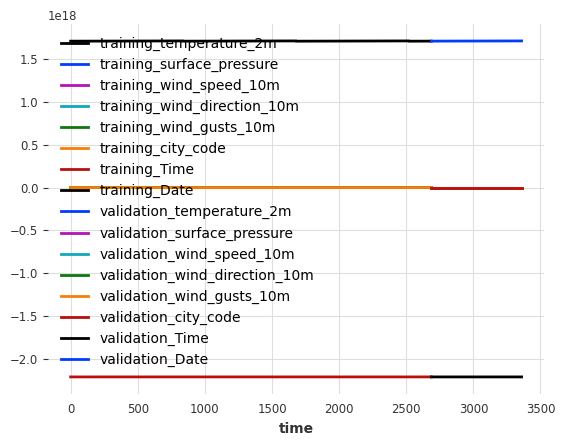

In [20]:
train, val = (scaled_ts).split_before(0.8)# (we standardize by dividing by 100 since Google Trends data tops out at 100 by default!)
train.plot(label="training")
val.plot(label="validation")

In [21]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# stop training when validation loss does not decrease more than 0.05 (`min_delta`) over
# a period of 5 epochs (`patience`)
my_stopper = EarlyStopping(
    monitor="val_loss",
    patience=30,
    min_delta=0.005,
    mode='min',
)

pl_trainer_kwargs={"callbacks": [my_stopper],
                   "accelerator": "cpu"}

In [22]:
# predict 3 days considering the latest 7 days

model_pastcov = BlockRNNModel(
    model="LSTM",
    input_chunk_length=7,
    output_chunk_length=3,
    dropout=0.2,
    torch_metrics=SymmetricMeanAbsolutePercentageError(),
    n_epochs=2,
    pl_trainer_kwargs = pl_trainer_kwargs,
    random_state=0,
)

In [23]:
train['surface_pressure']

<TimeSeries (DataArray) (time: 2687, component: 1, sample: 1)> Size: 21kB
array([[[942.98919678]],

       [[942.3739624 ]],

       [[941.57092285]],

       ...,

       [[987.76654053]],

       [[988.10845947]],

       [[988.63049316]]])
Coordinates:
  * time       (time) int64 21kB 0 1 2 3 4 5 6 ... 2681 2682 2683 2684 2685 2686
  * component  (component) object 8B 'surface_pressure'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [24]:
model_pastcov.fit(
    series=[train['surface_pressure']],    # the target training data
    past_covariates=train,     # the multi covariate features training data
    val_series=[val['surface_pressure']],  # the target validation data
    val_past_covariates=val,   # the multi covariate features validation data
    verbose=True,
)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

BlockRNNModel(output_chunk_shift=0, model=LSTM, hidden_dim=25, n_rnn_layers=1, hidden_fc_sizes=None, dropout=0.2, input_chunk_length=7, output_chunk_length=3, torch_metrics=SymmetricMeanAbsolutePercentageError(), n_epochs=2, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x15de27e80>], 'accelerator': 'cpu'}, random_state=0)

Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: xlabel='time'>

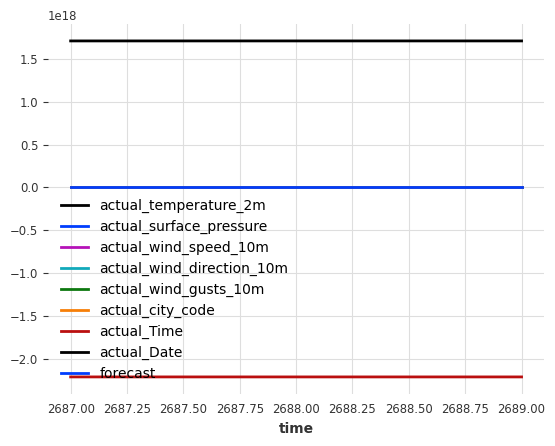

In [25]:
pred_cov = model_pastcov.predict(n=3,                        # n of days to predict
                                 series=train['surface_pressure'][-7:],  # target input for prediction
                                 past_covariates=train[-7:]) # past-covariates input for prediction

val[:3].plot(label="actual")
pred_cov.plot(label="forecast")

In [26]:
real_pred = pred_cov.values()

In [27]:
real_actual = val['surface_pressure'][:3].values()

In [28]:
real_pred.shape,real_actual.shape

((3, 1), (3, 1))

In [29]:
# check the SMAPE Symmetric Mean Absolute Percentage Error

def smape(y_true, y_hat):
    return 200.0 * np.mean(np.abs(y_true - y_hat) / (np.abs(y_true) + np.abs(y_hat)))

smape(real_actual, real_pred)

199.59710341898085